In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib
import urllib.request
from datetime import datetime, timedelta, date
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
import altair as alt
import streamlit as st
import statsmodels.api as sm

In [2]:
variable = 'new_cases_'
initialdate = '2020-01-01'   # first day of the year, where most of our data starts
# moving intialdate by 6, since we later apply 7-day rolling mean to our data:
initialdateshift = str(date.fromordinal(datetime.strptime(initialdate, '%Y-%m-%d').toordinal() + 6)) 
enddate = str(date.fromordinal(date.today().toordinal()-1))   # yesterday's date: last day of available data

country = 'Denmark'
col = variable + country
url1 = 'https://raw.githubusercontent.com/martaarozarena/KSchool-Master-Final-Project/master/data/endogenous.csv'
covid_ctry_varR = pd.read_csv(url1, parse_dates=['date'], index_col=['date'], usecols=['date', col])

In [3]:
url2 = 'https://raw.githubusercontent.com/martaarozarena/KSchool-Master-Final-Project/master/data/exogenous.csv'
exog = pd.read_csv(url2, parse_dates=['date'], index_col=['date'])
exog = exog.loc[:, exog.columns.str.contains(country)]

In [4]:
exog.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08',
               '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12',
               '2020-09-13', '2020-09-14'],
              dtype='datetime64[ns]', name='date', length=258, freq=None)

In [50]:
exog.iloc[-1, exog.columns.str.contains('Testing|Contact')]

H2_Testing policy_Denmark     3.0
H3_Contact tracing_Denmark    2.0
Name: 2020-09-14 00:00:00, dtype: float64

In [51]:
last_test_value = exog.iloc[-1, exog.columns.str.contains('Testing|Contact')][0]
int(last_test_value)

3

In [48]:
last_contact_value = exog.iloc[-1, exog.columns.str.contains('Testing|Contact')][1]
last_contact_value

2.0

In [38]:
exog.columns

Index(['positive_rate_Denmark', 'C1_School closing_Denmark',
       'C2_Workplace closing_Denmark', 'C3_Cancel public events_Denmark',
       'C4_Restrictions on gatherings_Denmark',
       'C5_Close public transport_Denmark',
       'C6_Stay at home requirements_Denmark',
       'C7_Restrictions on internal movement_Denmark',
       'C8_International travel controls_Denmark',
       'H1_Public information campaigns_Denmark', 'H2_Testing policy_Denmark',
       'H3_Contact tracing_Denmark', 'mask_Denmark', 'flightsArr_Denmark'],
      dtype='object')

In [5]:
forecastdays = 14
new_begin = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + 1))
new_date = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + forecastdays))
new_index = pd.date_range(initialdate, new_date, freq='D')
exog_futur = exog.reindex(new_index).interpolate()

In [6]:
exog_futur.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23',
               '2020-09-24', '2020-09-25', '2020-09-26', '2020-09-27',
               '2020-09-28', '2020-09-29'],
              dtype='datetime64[ns]', length=273, freq='D')

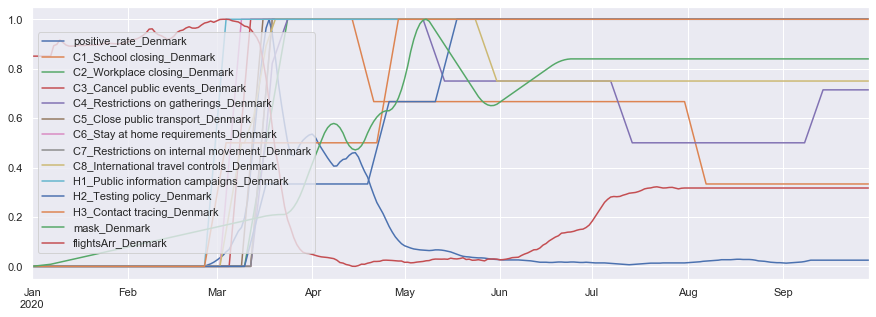

In [8]:
sc_in_fc = MinMaxScaler(feature_range=(0, 1))
scaled_input_fc = sc_in_fc.fit_transform(exog_futur)
scaled_input_fc = pd.DataFrame(scaled_input_fc, index=exog_futur.index, columns=exog_futur.columns)
X_fc = scaled_input_fc
X_fc.plot()

In [9]:
url3 = 'https://github.com/martaarozarena/KSchool-Master-Final-Project/raw/master/models/' + country +'SARIMAXmodel.pkl'
model = joblib.load(urllib.request.urlopen(url3))

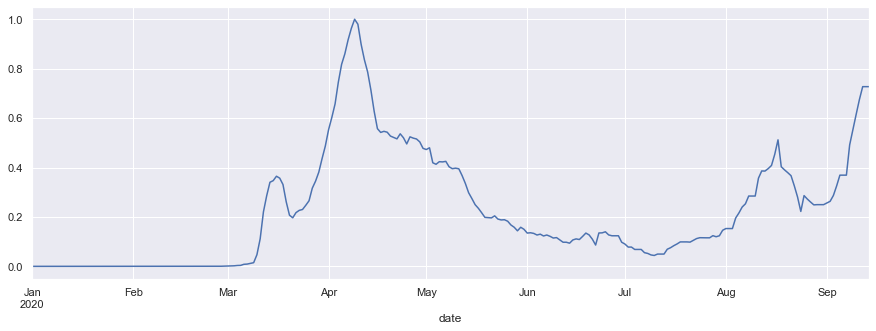

In [11]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(covid_ctry_varR)
scaled_output  = pd.Series(scaled_output.flatten(), index=covid_ctry_varR.index, name=covid_ctry_varR.columns[0])
scaled_output.plot()

In [12]:
scaled_output.name

'new_cases_Denmark'

In [17]:
past_rs = covid_ctry_varR.reset_index()

In [18]:
results = model.get_forecast(steps=14, exog=X_fc[new_begin:new_date])
mean_forecast = results.predicted_mean

forecast14 = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
forecast14S = pd.Series(forecast14.flatten(), index=mean_forecast.index, name='new_cases_forecast')
future_rs = forecast14S.to_frame().reset_index()

In [19]:
# Get confidence intervals of  predictions
confidence_intervals = results.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower ' + scaled_output.name]
upper_limits = confidence_intervals.loc[:,'upper ' + scaled_output.name]

forecast14_ll = sc_out.inverse_transform(lower_limits.values.reshape(-1,1))
forecast14_llS = pd.Series(forecast14_ll.flatten(), index=lower_limits.index, name='new_cases_forecast_ll')
fcast_ll_df = forecast14_llS.to_frame().reset_index()

forecast14_ul = sc_out.inverse_transform(upper_limits.values.reshape(-1,1))
forecast14_ulS = pd.Series(forecast14_ul.flatten(), index=upper_limits.index, name='new_cases_forecast_ul')
fcast_ul_df = forecast14_ulS.to_frame().reset_index()

In [20]:
conf_int = pd.concat([fcast_ll_df, fcast_ul_df.iloc[:, 1]], axis=1)
conf_int

,index,new_cases_forecast_ll,new_cases_forecast_ul
0,2020-09-15,224.429789,251.770276
1,2020-09-16,213.087755,262.772357
2,2020-09-17,203.019780,272.664451
3,2020-09-18,194.161471,281.431764
4,2020-09-19,186.315082,289.231076
5,2020-09-20,179.282497,296.239303
6,2020-09-21,172.899704,302.609494
7,2020-09-22,167.039126,308.463553
8,2020-09-23,161.603500,313.895806
9,2020-09-24,156.518806,318.978755


In [21]:
past_plt = alt.Chart(past_rs).mark_line().encode(
    x='date:T',
    y=col,
    tooltip=alt.Tooltip(col, format='.1f')
).properties(
    width=800,
    height=300
).interactive()

In [22]:
future_plt = alt.Chart(future_rs).mark_line(color='orange').encode(
    x=alt.X('index:T', axis=alt.Axis(title='Date')),
    y=alt.Y('new_cases_forecast', axis=alt.Axis(title='New coronavirus cases'), title='liijl'),
    tooltip=alt.Tooltip('new_cases_forecast', format='.1f')
).properties(
    width=800,
    height=300
).interactive()

In [24]:
confint_plot = alt.Chart(conf_int).mark_area(opacity=0.2, color='orange').encode(
    alt.X('index:T'),
    alt.Y('new_cases_forecast_ll'),
    alt.Y2('new_cases_forecast_ul')
)

In [25]:
past_plt + future_plt + confint_plot

alt.LayerChart(...)

In [26]:
confint_plot = alt.Chart(conf_int).mark_area(opacity=0.2, color='orange').encode(
    alt.X('index:T'),
    alt.Y('new_cases_forecast_ll'),
    alt.Y2('new_cases_forecast_ul')
)
confint_plot

alt.Chart(...)

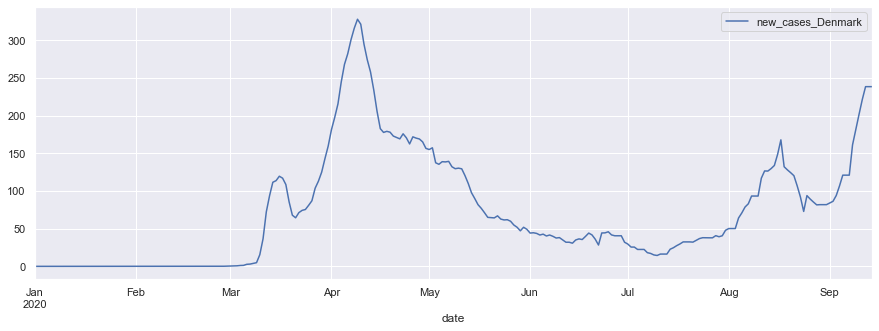

In [28]:
covid_ctry_varR.plot()

In [29]:
future_rs.columns[1]

'new_cases_forecast'

In [31]:
forecast14S_l = ["%.1f" % elem for elem in forecast14S]
print('Next 14 days forecast values: ', forecast14S_l)

Next 14 days forecast values:  ['238.1', '237.9', '237.8', '237.8', '237.8', '237.8', '237.8', '237.8', '237.7', '237.7', '237.7', '237.7', '237.7', '237.7']


In [63]:
future_rs

,index,new_cases_forecast
0,2020-09-15,238.100032
1,2020-09-16,237.930056
2,2020-09-17,237.842116
3,2020-09-18,237.796618
4,2020-09-19,237.773079
5,2020-09-20,237.760900
6,2020-09-21,237.754599
7,2020-09-22,237.751340
8,2020-09-23,237.749653
9,2020-09-24,237.748780


In [32]:
def get_model():
    url3 = 'https://github.com/martaarozarena/KSchool-Master-Final-Project/raw/master/models/' + country +'SARIMAXmodel.pkl'
    smodel = joblib.load(urllib.request.urlopen(url3))
#    smodel = sm.load_pickle('./models_old/SpainSARIMAXmodel_savedWithStatstools.pkl')
    return smodel

model =  get_model()

In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      new_cases_Denmark   No. Observations:                  258
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 624.890
Date:                Wed, 16 Sep 2020   AIC                          -1217.780
Time:                        14:07:37   BIC                          -1160.995
Sample:                    01-01-2020   HQIC                         -1194.944
                         - 09-14-2020                                         
Covariance Type:                  opg                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
positive_rate_Denmark                            0.4078      0.203      2.007      0.045       0.009       0.806
C1_School closing_Denmark                        0.1639      0.192      0.855      0.393      -0.212       0.540
C2_Workplace closing_Denmark                     0.3150      0.359      0.876      0.381      -0.389       1.020
C3_Cancel public events_Denmark                  0.0125      0.346      0.036      0.971      -0.666       0.691
C4_Restrictions on gatherings_Denmark            0.0542      0.351      0.154      0.877      -0.634       0.742
C5_Close public transport_Denmark                0.1463      0.426      0.343      0.731      -0.689       0.982
C6_Stay at home requirements_Denmark             0.1288      0.786      0.164      0.870      -1.412       1.670
C7_Restrictions on internal movement_Denmark    -0.5046      0.411     -1.227      0.220      -1.311       0.301
C8_International travel controls_Denmark        -0.3068      0.471     -0.651      0.515      -1.231       0.617
H1_Public information campaigns_Denmark         -0.0912      1.761     -0.052      0.959      -3.542       3.360
H2_Testing policy_Denmark                        0.0007      0.279      0.003      0.998      -0.546       0.547
H3_Contact tracing_Denmark                       0.1514      0.195      0.777      0.437      -0.231       0.533
mask_Denmark                                     0.6093      0.141      4.312      0.000       0.332       0.886
flightsArr_Denmark                               0.0020      0.292      0.007      0.994      -0.569       0.573
ar.L1                                            0.5174      0.039     13.330      0.000       0.441       0.593
sigma2                                           0.0005   1.71e-05     26.472      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       85.14   Jarque-Bera (JB):              1787.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.56   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""